##  Random Walk问题
问题来源：Reinforcement Learning An Introduction Second Edition P125

**提交人：杨星**

**51194506042**

A Markov reward process:
* all episodes start in the center state, C, then proceed either left
or right by one state on each step, with equal probability. 
* terminate either on the extreme left or the extreme right
    * When an episode terminates on the right, a reward of +1 occurs; all other rewards are zero.
    * **the true value of each state is the probability of terminating on the right if starting from that state**

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### 初始化状态价值和真实状态价值

In [131]:
# 随机初始化各个状态的状态价值
VALUES = np.zeros(7)
VALUES[1:6] = 0.5
VALUES[6] = 1

#设定真实的状态价值
TRUE_VALUE = np.zeros(7)
TRUE_VALUE[1:6] = np.arange(1, 6) / 6.0
TRUE_VALUE[6] = 1

ACTION_LEFT = 0
ACTION_RIGHT = 1

### 定义TF(0)算法
**价值更新的公式如下**：

$\begin{equation}
V\left(S_{t}\right) \leftarrow V\left(S_{t}\right)+\alpha\left[R_{t+1}+\gamma V\left(S_{t+1}\right)-V\left(S_{t}\right)\right]\end{equation}$

* $\alpha$可以设定
* 衰减率$\gamma$为1
* 由于TF(0)只需要当前状态和下一个状态就可以进行状态价值更新，所以我们可以边进行采样，边更新状态价值，
* TF(0)算法的优势就是不需要完整的状态序列

In [149]:
# @values: 当前的状态价值
# @alpha: 系数
def temporal_difference(values, alpha=0.1, batch=False):
    state = 3                       #所用状态都是从中间开始
    trajectory = [state]            # 采样得到的状态序列
    rewards = [0]                   # 定义列表用于存储，状态转移过程中的reward
    while True:
        old_state = state
        if np.random.binomial(1, 0.5) == ACTION_LEFT:   #定义了一个二项分布B(1,p),等概率产生0或1，进行状态转移
            state -= 1
        else:
            state += 1
        #定义状态转移奖励，只用转移到最右边会有奖励
        #  if state == 6:
        #     reward = 1
        # else:
        reward = 0
        trajectory.append(state)
        # TD update
        if not batch:            # 采用TF算法进行状态价值更新
            values[old_state] += alpha * (reward + values[state] - values[old_state])
        if state == 6 or state == 0: # 到达状态序列结尾，终止
            break
        rewards.append(reward) 
    return trajectory, rewards   #将一次完整的状态序列以及奖励放进列表存储返回

### 使用TF(0)方法计算状态价值

In [154]:
def compute_state_value():
    episodes = [0, 1, 10, 100,500,1000]        #定义训练轮数
    current_values = np.copy(VALUES)          #读取之前的状态价值
    plt.figure(1)
    for i in range(episodes[-1] + 1):  
        if i in episodes:
            plt.plot(current_values, label=str(i) + ' episodes')
        temporal_difference(current_values)
    plt.plot(TRUE_VALUE, label='true values')
    plt.xlabel('state')
    plt.ylabel('estimated value')
    plt.legend(loc = 'upper left')

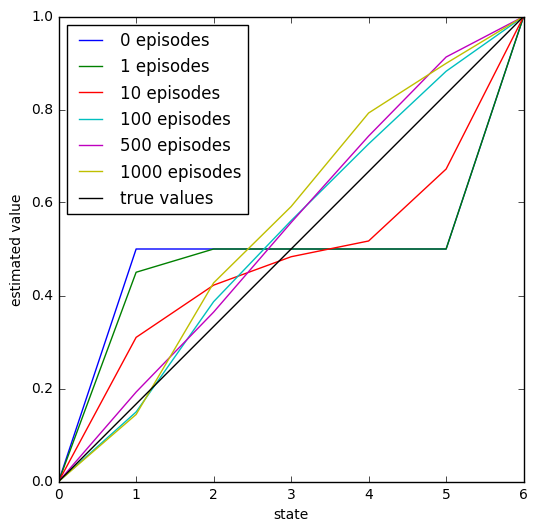

In [155]:
plt.figure(figsize=(6, 6))
compute_state_value()

**该图像画出了各个状态的价值，可以发现迭代次数增大时，TF算法得到的值与true value相接近**

### 定义const-$\alpha$ MC算法
**状态价值更新如下：**

$\begin{equation}
V\left(S_{t}\right) \leftarrow V\left(S_{t}\right)+\alpha\left[G_{t}-V\left(S_{t}\right)\right]
\end{equation}$

* G(t)是从初始状态到终止状态总的reward
* MC算法需要完整的序列，所以需要先进行采样，才能进行状态价值的更新



In [143]:
def monte_carlo(values, alpha=0.1, batch=False):
    state = 3
    trajectory = [3]              #从中间状态开始
    # if end up with left terminal state, all returns are 0
    # if end up with right terminal state, all returns are 1
    while True:                           # 在MC算法中需要先得到完整的状态序列，即采用的序列一定要到达终止状态
        if np.random.binomial(1, 0.5) == ACTION_LEFT:
            state -= 1
        else:
            state += 1
        trajectory.append(state)
        if state == 6:
            returns = 1.0
            break
        elif state == 0:
            returns = 0.0
            break

    if not batch:                         # 进行状态价值的更新
        for state_ in trajectory[:-1]:
            # MC update
            values[state_] += alpha * (returns - values[state_])
    return trajectory, [returns] * (len(trajectory) - 1)


### 计算了均方误差

In [144]:
def rms_error():
    td_alphas = [0.15, 0.1, 0.05]                   #设置参数
    mc_alphas = [0.01, 0.02, 0.03, 0.04]
    episodes = 100 + 1
    runs = 100
    for i, alpha in enumerate(td_alphas + mc_alphas):
        total_errors = np.zeros(episodes)
        if i < len(td_alphas):
            method = 'TD'
            linestyle = 'solid'
        else:
            method = 'MC'
            linestyle = 'dashdot'
        for r in range(runs):
            errors = []
            current_values = np.copy(VALUES)
            for i in range(0, episodes):
                errors.append(np.sqrt(np.sum(np.power(TRUE_VALUE - current_values, 2)) / 5.0))
                if method == 'TD':
                    temporal_difference(current_values, alpha=alpha)
                else:
                    monte_carlo(current_values, alpha=alpha)
            total_errors += np.asarray(errors)
        total_errors /= runs
        plt.plot(total_errors, linestyle=linestyle, label=method + ', alpha = %.02f' % (alpha))
    plt.xlabel('episodes')
    plt.ylabel('RMS')
    plt.legend()

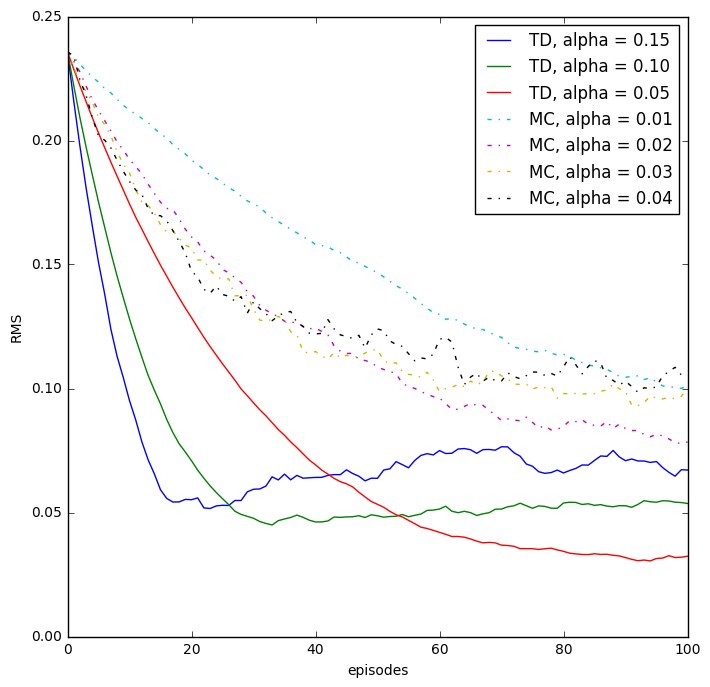

In [145]:
plt.figure(figsize=(8, 8))
rms_error()

### 采用2种算法以及不同的$\alpha$得到的状态价值与真实状态价值的的均方误差
* 在本问题中TF(0)算法要比MC算法收敛的更加快
* 发现随着迭代次数增加，均方误差总体是减少的
* 无论采用哪种算法，当$\alpha$取值减小，虽然需要更多的迭代次数才能收敛到一个较稳定的误差值，但相较于取较大的$\alpha$,收敛过程更加平稳，不容易抖动，并且相同迭代次数的情况下，损失更加小